In [3]:
pip install fairlearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Кирилл\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_boston
from typing import Union, Tuple

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [5]:

k1 = 8
k2 = 2
total = k1 + k2
p_k1 = k1 / total
p_k2 = k2 / total

entropy = - (p_k1 * np.log(p_k1) + p_k2 * np.log(p_k2))

entropy_okrug = np.round(entropy, 2)

print(entropy_okrug)

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [6]:
H_Rm = p_k1 * (1 - p_k1) + p_k2 * (1 - p_k2)
H_Rl = 1 * (1 - 1) + 0 * (1 - 0)
H_Rr = 0 * (1 - 0) + 1 * (1 - 1)
Q = H_Rm - (8 / 10) * H_Rl - (2 / 10) * H_Rr

Q_okrug = np.round(Q, 2)
print(Q_okrug)

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [7]:
values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
predict = sum(values) / len(values)
print(predict)

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [8]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [9]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    import numpy as np

    
    if np.unique(feature_vector).size == 1:
        return np.array([]), np.array([]), None, -np.inf

    
    order = np.argsort(feature_vector)
    X_sorted = feature_vector[order]
    y_sorted = target_vector[order]

    
    if feature_type == "real":
        diffs = np.diff(X_sorted)
        valid = diffs > 0
        thresholds = (X_sorted[1:][valid] + X_sorted[:-1][valid]) / 2
    else:
        thresholds = np.unique(X_sorted)

    
    if feature_type == "real":
        masks = np.less.outer(X_sorted, thresholds)
    else:
        masks = np.equal.outer(X_sorted, thresholds)

    left_counts = masks.sum(axis=0)
    right_counts = len(X_sorted) - left_counts

    
    valid_mask = (left_counts > 0) & (right_counts > 0)
    thresholds = thresholds[valid_mask]
    masks = masks[:, valid_mask]

    if task == "classification":
        def gini_impurity(y):
            if y.size == 0:
                return 0.0
            probs = np.bincount(y) / len(y)
            return 1.0 - np.sum(probs**2)

        parent_impurity = gini_impurity(y_sorted)
        left_impurity = np.array([
            gini_impurity(y_sorted[mask]) for mask in masks.T
        ])
        right_impurity = np.array([
            gini_impurity(y_sorted[~mask]) for mask in masks.T
        ])
    else:
        parent_impurity = np.var(y_sorted)
        left_impurity = np.array([
            np.var(y_sorted[mask]) if np.any(mask) else 0.0 for mask in masks.T
        ])
        right_impurity = np.array([
            np.var(y_sorted[~mask]) if np.any(~mask) else 0.0 for mask in masks.T
        ])

    n_total = len(y_sorted)
    n_left = masks.sum(axis=0)
    n_right = n_total - n_left

    weighted_impurity = (n_left / n_total) * left_impurity + (n_right / n_total) * right_impurity
    gains = parent_impurity - weighted_impurity

    
    best_idx = np.argmax(gains)
    best_threshold = thresholds[best_idx]
    best_gain = gains[best_idx]

    return thresholds, gains, best_threshold, best_gain


Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [10]:
boston = fetch_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

feature_vector = X["CRIM"].values
target_vector = y.values


print(boston["DESCR"])

C:\Users\Кирилл\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\datasets\_fetch_boston.py:133: DataFairnessWarning: You are about to use a dataset with known fairness issues.
  warnings.warn(DataFairnessWarning(msg))


**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

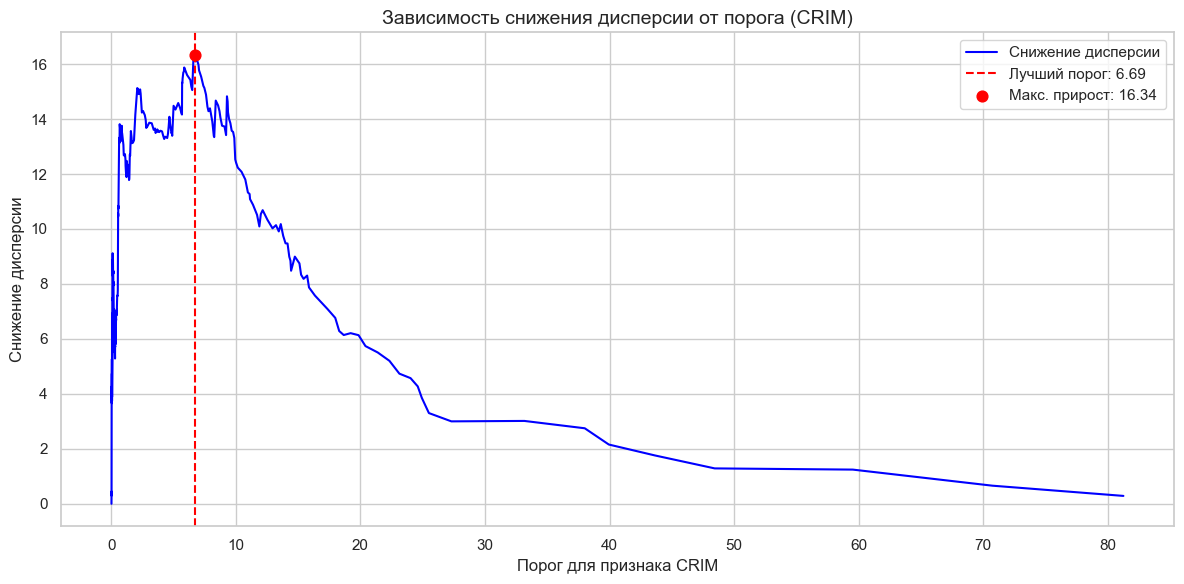

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml


boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data
y = boston.target

feature_vector = X["CRIM"].values
target_vector = y.values


print(boston.DESCR)


thresholds, gains, best_threshold, best_gain = find_best_split(
    feature_vector,
    target_vector,
    task="regression",
    feature_type="real"
)


sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(x=thresholds, y=gains, ax=ax, label="Снижение дисперсии", color="blue")
ax.axvline(x=best_threshold, linestyle="--", color="red", label=f"Лучший порог: {best_threshold:.2f}")
ax.scatter([best_threshold], [best_gain], color="red", s=60, zorder=5, label=f"Макс. прирост: {best_gain:.2f}")

ax.set_xlabel("Порог для признака CRIM", fontsize=12)
ax.set_ylabel("Снижение дисперсии", fontsize=12)
ax.set_title("Зависимость снижения дисперсии от порога (CRIM)", fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [12]:
class DecisionTree:

    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:

        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini is None:
                continue

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                threshold_best = threshold

                if feature_type == "real":
                    split = feature_vector < threshold  
                elif feature_type == "categorical":
                    split = feature_vector == threshold  
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            if self.task == "classification":
                node["class"] = Counter(sub_y).most_common(1)[0][0]
            else:
                node["class"] = np.mean(sub_y)
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
            if x[feature] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)


**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

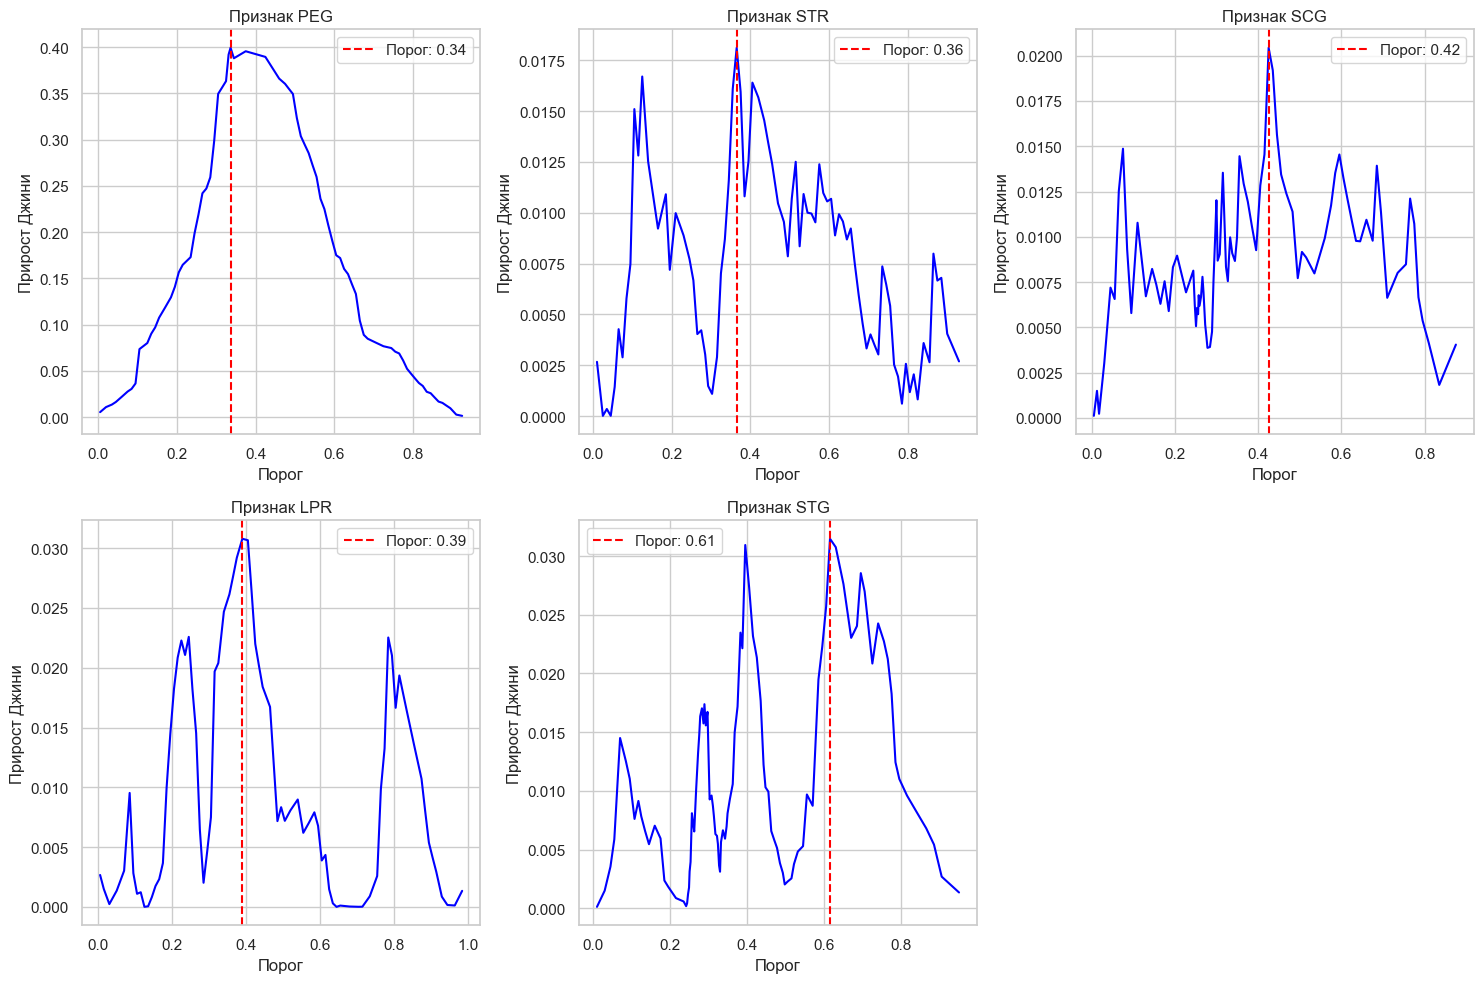

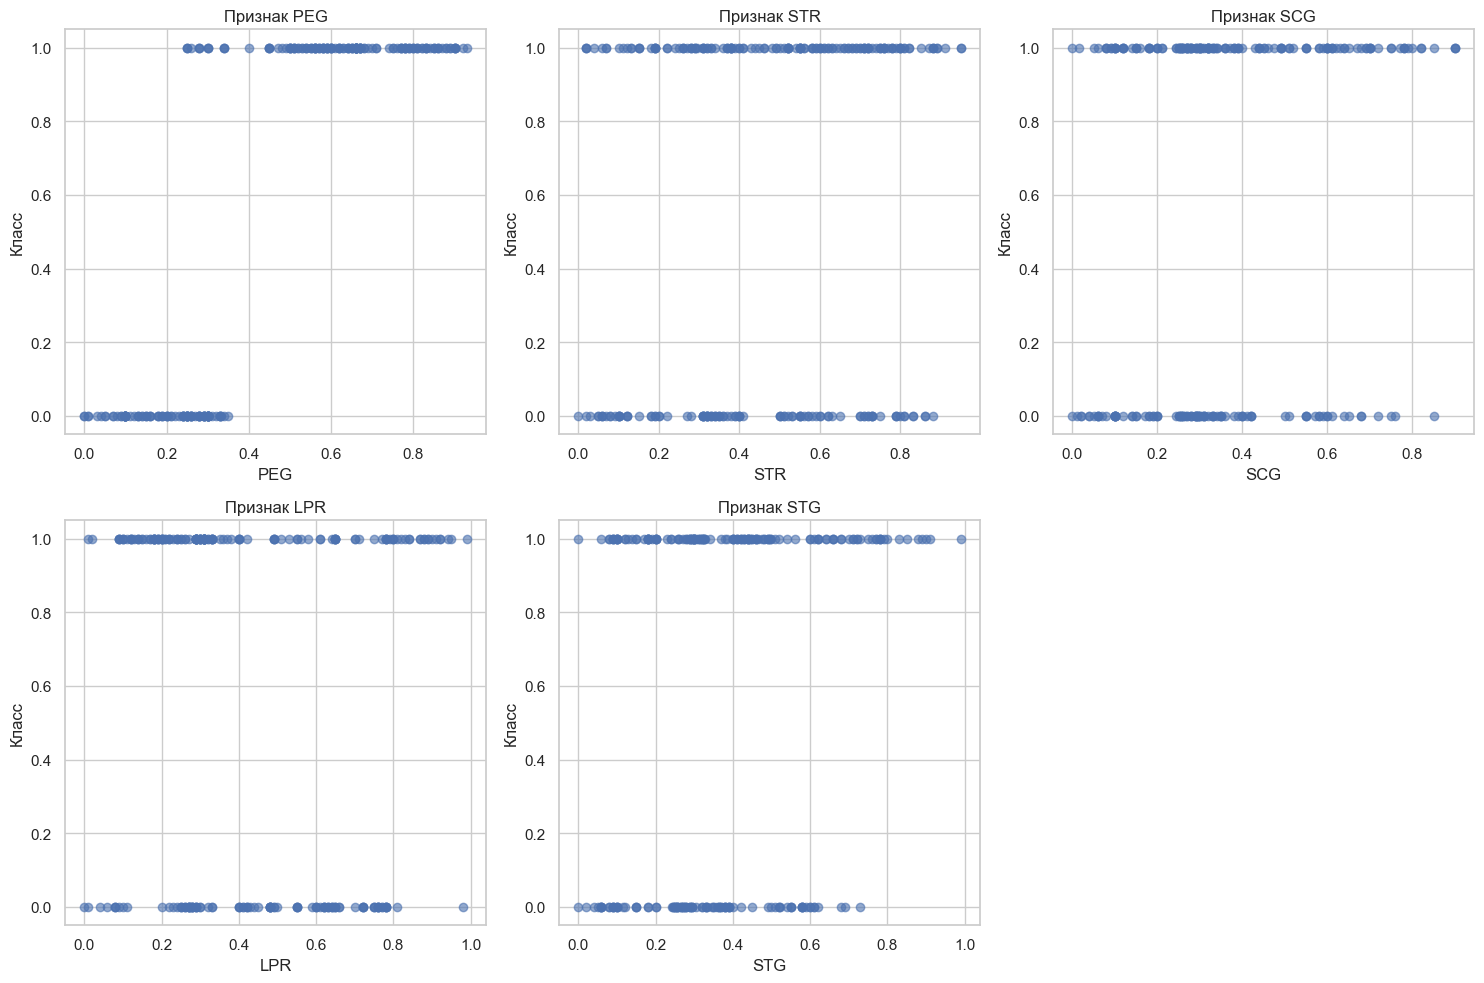

In [25]:



file_path = r'C:\Users\Кирилл\Downloads\students.csv'
students = pd.read_csv(file_path)


feature_list = ['PEG', 'STR', 'SCG', 'LPR', 'STG']
target_col = 'UNS'


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()

for idx, col in enumerate(feature_list):
    x_values = students[col].to_numpy()
    y_values = students[target_col].to_numpy()

    thresholds, gains, best_threshold, best_gain = find_best_split(
        x_values, y_values,
        task="classification",
        feature_type="real"
    )

    if thresholds.size > 0:
        ax = axs[idx]
        ax.plot(thresholds, gains, color='blue', linewidth=1.5)
        ax.axvline(best_threshold, color='red', linestyle='--', label=f'Порог: {best_threshold:.2f}')
        ax.set_title(f'Признак {col}')
        ax.set_xlabel('Порог')
        ax.set_ylabel('Прирост Джини')
        ax.legend()


if len(feature_list) < len(axs):
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feat in enumerate(feature_list):
    axes[i].scatter(students[feat], students[target_col], alpha=0.6)
    axes[i].set_title(f'Признак {feat}')
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Класс')


if len(feature_list) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

 PEG даёт наилучшее разделение выборки

 На диаграммах видно, что признак PEG наиболее чётко разделяет классы. 

Кривая Джини для хороших признаков имеет узкий пик, производная к пику растет

Для плохих признаков наоборот   

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [14]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = ['target', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
           'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
           'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
           'stalk-surface-below-ring', 'stalk-color-above-ring',
           'stalk-color-below-ring', 'veil-type', 'veil-color',
           'ring-number', 'ring-type', 'spore-print-color',
           'population', 'habitat']
mushrooms = pd.read_csv(url, header=None, names=columns)


le = LabelEncoder()
for col in mushrooms.columns:
    mushrooms[col] = le.fit_transform(mushrooms[col])


X = mushrooms.drop('target', axis=1).values
y = mushrooms['target'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


feature_types = ['categorical'] * (X.shape[1]) 
tree = DecisionTree(feature_types=feature_types, task="classification")
tree.fit(X_train, y_train)


predictions = tree.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy:.4f}")


print("\nРаспределение классов в тестовой выборке:")
print(f"Съедобные (e): {np.sum(y_test == 0)}")
print(f"Ядовитые (p): {np.sum(y_test == 1)}")
print(f"Общее количество: {len(y_test)}")

Accuracy: 1.0000

Распределение классов в тестовой выборке:
Съедобные (e): 2085
Ядовитые (p): 1977
Общее количество: 4062


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [15]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [16]:
file_path = r'C:\Users\Кирилл\Downloads\diabetes.csv'
data = pd.read_csv(file_path)
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

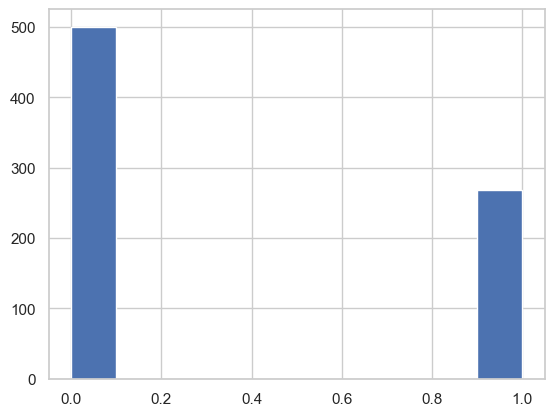

In [17]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [18]:



X = data.drop('Outcome', axis=1)
y = data['Outcome']


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val
)


print("Размеры выборок:")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Валидационная выборка: {X_val.shape}")
print(f"Тестовая выборка: {X_test.shape}")


Размеры выборок:
Обучающая выборка: (375, 8)
Валидационная выборка: (162, 8)
Тестовая выборка: (231, 8)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [19]:
from sklearn.metrics import f1_score



depths = [3, 5, 7, 10, 15, 20, None]
leaf_sizes = [1, 2, 5, 10, 20]

best_f1 = -1
optimal_depth, optimal_leaf = None, None

for depth in depths:
    for leaf in leaf_sizes:
        clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=42)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_train_val)
        score = f1_score(y_train_val, preds)

        if score > best_f1:
            best_f1 = score
            optimal_depth = depth
            optimal_leaf = leaf

print(f"Лучшие параметры: max_depth={optimal_depth}, min_samples_leaf={optimal_leaf}")
print(f"F1 на валидации: {best_f1:.4f}")


final_clf = DecisionTreeClassifier(
    max_depth=optimal_depth,
    min_samples_leaf=optimal_leaf,
    random_state=42
)
final_clf.fit(X_train, y_train)


y_pred = final_clf.predict(X_test)
y_proba = final_clf.predict_proba(X_test)[:, 1]

print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")


Лучшие параметры: max_depth=15, min_samples_leaf=1
F1 на валидации: 0.8333
Accuracy:  0.6970
Precision: 0.5714
Recall:    0.5432
ROC-AUC:   0.6616


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [20]:
from sklearn.ensemble import BaggingClassifier



bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=0),
    n_estimators=50,
    random_state=0
)


bagging_clf.fit(X_train , y_train)


y_pred_bagging = bagging_clf.predict(X_test)
y_proba_bagging = bagging_clf.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred_bagging)
precision = precision_score(y_test, y_pred_bagging)
recall = recall_score(y_test, y_pred_bagging)
roc_auc = roc_auc_score(y_test, y_proba_bagging)

print("BaggingClassifier (50 деревьев):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


BaggingClassifier (50 деревьев):
Accuracy: 0.7576
Precision: 0.6984
Recall: 0.5432
ROC AUC: 0.8286


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [21]:
from sklearn.model_selection import StratifiedKFold


max_depth_values = [3, 5, 7, 10]
min_samples_split_values = [2, 5, 10]

best_f1 = -1
best_params = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        f1_scores = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

            clf = RandomForestClassifier(
                n_estimators=50,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=0
            )
            clf.fit(X_train_cv, y_train_cv)
            y_val_pred = clf.predict(X_val_cv)
            f1 = f1_score(y_val_cv, y_val_pred)
            f1_scores.append(f1)

        avg_f1 = np.mean(f1_scores)

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_params = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split
            }

print("Лучшие параметры для Random Forest:", best_params)
print("Средняя F1-мера на кросс-валидации:", best_f1)


final_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=0
)
final_rf.fit(X_train, y_train)


y_pred_rf = final_rf.predict(X_test)
y_proba_rf = final_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)

print("RandomForestClassifier (50 деревьев):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Лучшие параметры для Random Forest: {'max_depth': 10, 'min_samples_split': 2}
Средняя F1-мера на кросс-валидации: 0.6338465077595512
RandomForestClassifier (50 деревьев):
Accuracy: 0.7792
Precision: 0.7344
Recall: 0.5802
ROC AUC: 0.8202


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

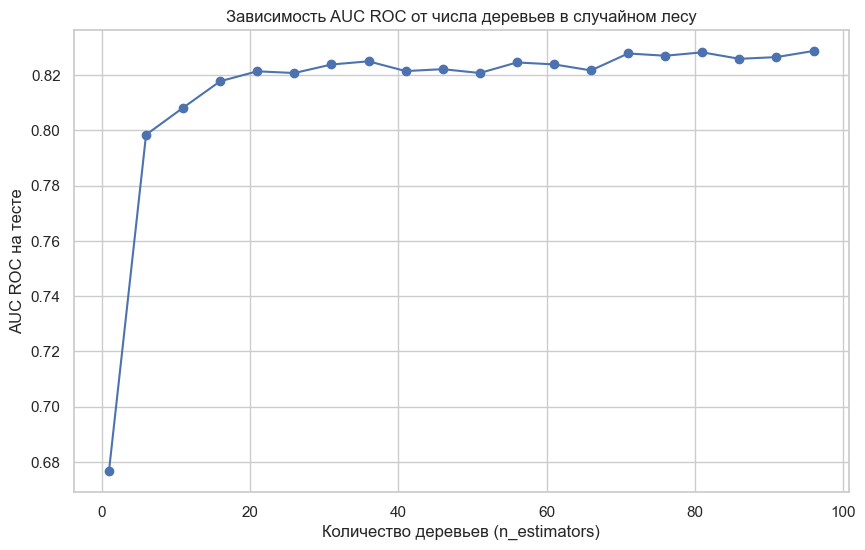

In [22]:


n_estimators_list = list(range(1, 101, 5))
auc_scores = []

for n in n_estimators_list:
    clf = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_params['max_depth'],              
        min_samples_split=best_params['min_samples_split'],
        random_state=0
    )
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, auc_scores, marker='o')
plt.xlabel("Количество деревьев (n_estimators)")
plt.ylabel("AUC ROC на тесте")
plt.title("Зависимость AUC ROC от числа деревьев в случайном лесу")
plt.grid(True)
plt.show()


**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

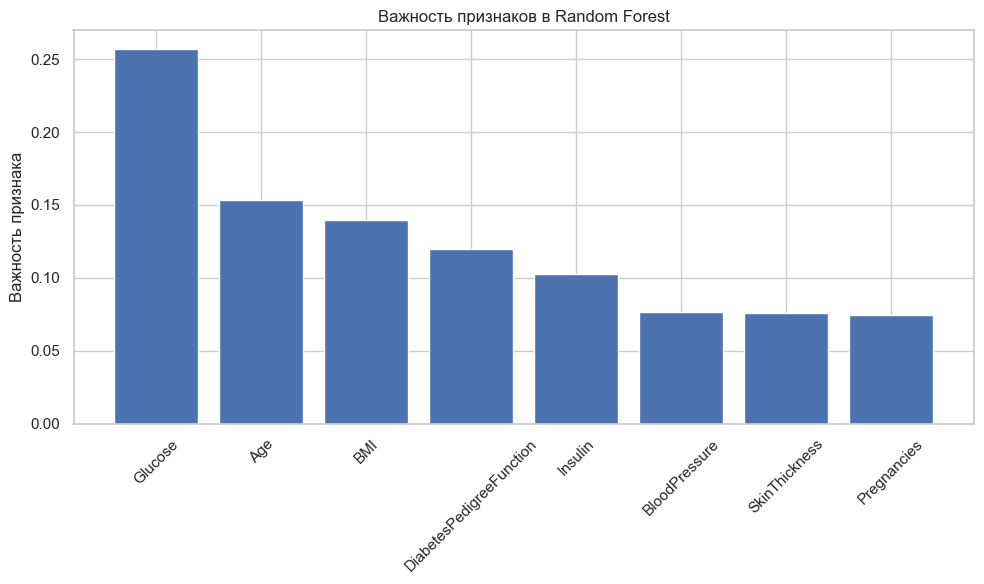

Самый важный признак для определения диабета: Glucose


In [23]:
rf_best = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=0
)
rf_best.fit(X_train, y_train)


importances = rf_best.feature_importances_
feature_names = X.columns 
indices = np.argsort(importances)[::-1]  

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.ylabel("Важность признака")
plt.title("Важность признаков в Random Forest")
plt.tight_layout()
plt.show()


most_important_feature = feature_names[indices[0]]
print(f"Самый важный признак для определения диабета: {most_important_feature}")
